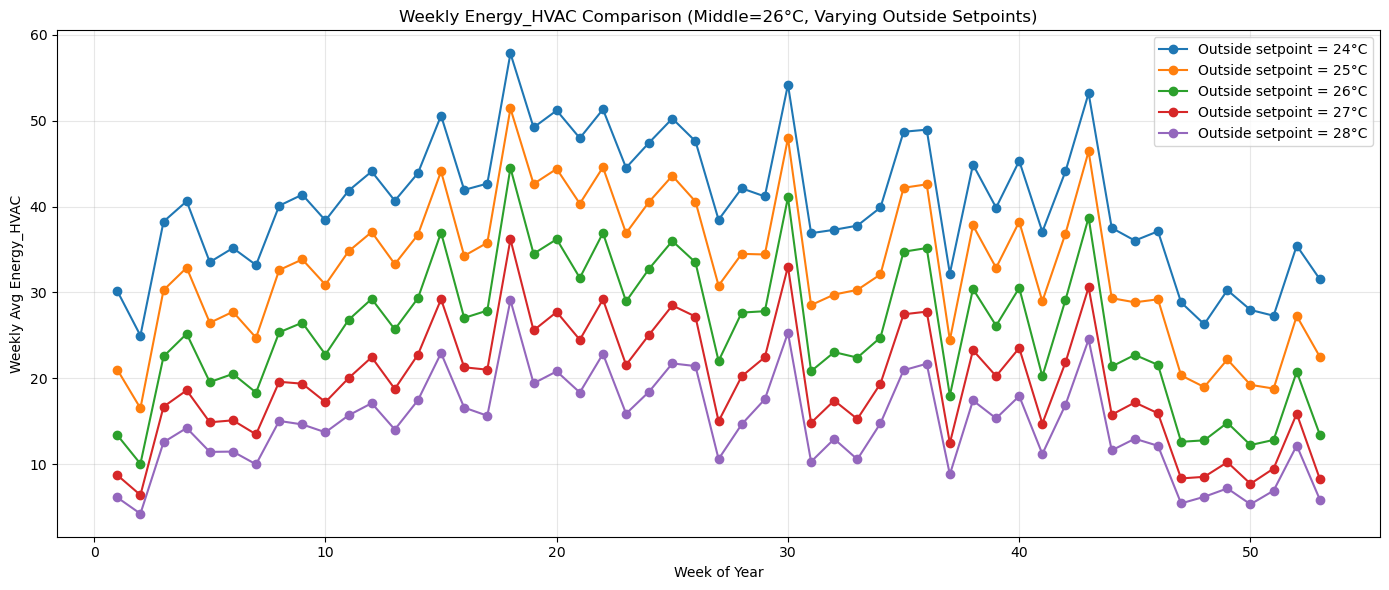

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取文件
df = pd.read_csv("prediction.csv")

# ----------------------------
# 创建 week 列（ISO 周）
# dayofyear: 1~365
# week = (dayofyear-1)//7 + 1  → 周编号 1~52
# ----------------------------
df['week'] = (df['dayofyear'] - 1) // 7 + 1

# ----------------------------
# 固定 middle = 26°C
# ----------------------------
df_mid26 = df[df['Tset_middle'] == 26]

# ----------------------------
# 获取 outside 的所有温度 setpoint
# ----------------------------
outside_values = sorted(df_mid26['Tset_outside'].unique())

# ----------------------------
# 计算每个 outside setpoint 的每周平均 E_HVAC
# ----------------------------
weekly_dict = {}

for val in outside_values:
    df_sp = df_mid26[df_mid26['Tset_outside'] == val]
    weekly_mean = df_sp.groupby('week')['E_HVAC'].mean()
    weekly_dict[val] = weekly_mean

# ----------------------------
# 作图
# ----------------------------
plt.figure(figsize=(14,6))

for val in outside_values:
    plt.plot(
        weekly_dict[val].index,
        weekly_dict[val].values,
        marker='o',
        label=f"Outside setpoint = {val}°C"
    )

plt.xlabel("Week of Year")
plt.ylabel("Weekly Avg Energy_HVAC")
plt.title("Weekly Energy_HVAC Comparison (Middle=26°C, Varying Outside Setpoints)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [24]:
display(df.head())

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Diffuse Horizontal Radiation,Energy,Energy.1,Energy.2,Energy.3,Energy.4,Energy.5,...,E_equipment,E_HVAC,E_building_real,Dry Bulb Temperature_lag1,Dry Bulb Temperature_lag2,Relative Humidity_lag1,Relative Humidity_lag2,Diffuse Horizontal Radiation_lag1,Diffuse Horizontal Radiation_lag2,week
0,25.6,24.7,95,0,8.119193,7.303527,11.028523,2.515576,3.542057,5.693886,...,5.598523,25.976884,32.423259,25.0,25.0,100.0,94.0,0.0,0.0,1
1,26.0,25.0,94,0,8.331287,7.146449,11.354523,2.591383,3.671886,5.863833,...,5.598523,26.434024,32.880398,25.6,25.0,95.0,100.0,0.0,0.0,1
2,26.0,25.0,94,0,7.945468,6.353466,10.785413,2.480894,3.512707,5.577643,...,5.598523,24.644547,31.090921,26.0,25.6,94.0,95.0,0.0,0.0,1
3,25.3,24.9,98,0,7.373752,5.398101,9.948663,2.310844,3.262461,5.139871,...,5.598523,22.315666,28.682004,26.0,26.0,94.0,94.0,0.0,0.0,1
4,25.0,25.0,100,0,7.173191,4.787212,9.699169,2.256957,3.192528,4.987545,...,5.598523,21.756969,28.123307,25.3,26.0,98.0,94.0,0.0,0.0,1


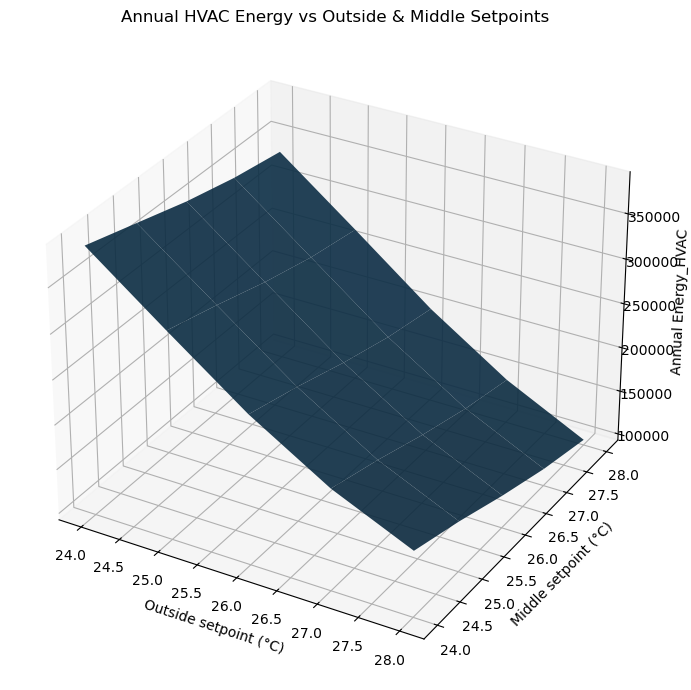

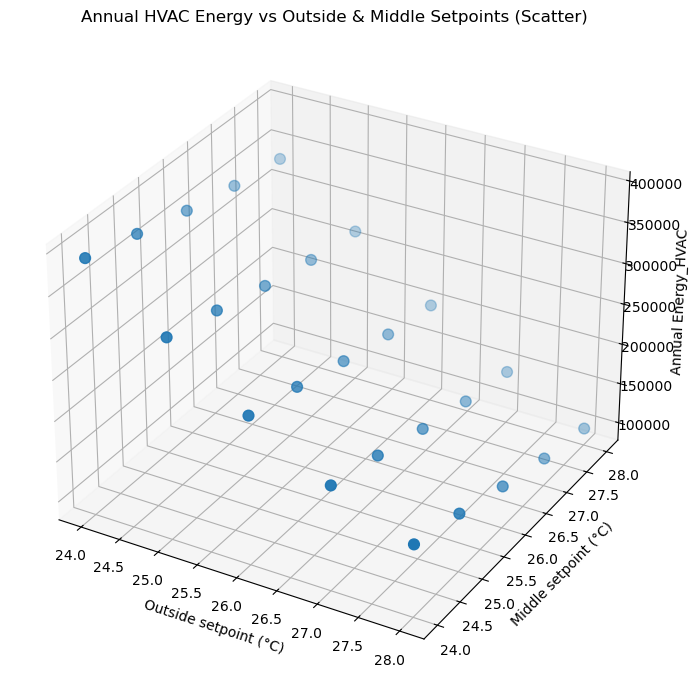

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 只为激活 3D

# 1. 读数据
df = pd.read_csv("preprocess.csv")

energy_col = "E_HVAC"

# 2. 按 outside / middle 分组合计全年能耗
annual = (
    df.groupby(['Tset_outside', 'Tset_middle'])[energy_col]
      .sum()
      .reset_index()
)

# 3. 做成 5×5 的矩阵，行：middle，列：outside
pivot = annual.pivot(index='Tset_middle',
                     columns='Tset_outside',
                     values=energy_col)

# 排序一下，保证坐标轴有序
pivot = pivot.sort_index().sort_index(axis=1)

outside_vals = pivot.columns.values   # x 轴：outside setpoint
middle_vals  = pivot.index.values     # y 轴：middle setpoint
X, Y = np.meshgrid(outside_vals, middle_vals)
Z = pivot.values                      # z 轴：全年能耗

# 4. 画 3D surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, alpha=0.9)

ax.set_xlabel("Outside setpoint (°C)")
ax.set_ylabel("Middle setpoint (°C)")
ax.set_zlabel("Annual Energy_HVAC")
ax.set_title("Annual HVAC Energy vs Outside & Middle Setpoints")

# 加一个颜色条（可选）
#fig.colorbar(surf, shrink=0.5, aspect=10, label="Annual Energy_HVAC")

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(annual['Tset_outside'],
           annual['Tset_middle'],
           annual[energy_col],
           s=60)

ax.set_xlabel("Outside setpoint (°C)")
ax.set_ylabel("Middle setpoint (°C)")
ax.set_zlabel("Annual Energy_HVAC")
ax.set_title("Annual HVAC Energy vs Outside & Middle Setpoints (Scatter)")

plt.tight_layout()
plt.show()

